In [3]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [4]:
import bs_unitaries1 as bs

In [5]:
linit=np.array([2.42989539e+02,-1.21958638e+00,  1.16977027e+00,  3.94347014e-01,  4.18138649e-01,
 -3.63177974e-01,  3.66936856e-01,  1.14825348e+00,  9.44881553e-01,
  4.76602659e-01 ,-5.08380239e-01,  6.44845993e-01,  9.24789209e-01,
 -1.06035373e+00, -4.79018020e-01,  6.27273684e-01 , 1.72509477e+00,
  2.29120908e-01, -2.82348606e-01, -5.69182891e-02,  1.61783041e+00,
  2.85935176e-01, -1.80553841e+00,  1.43291946e+00, -1.43186197e+00,
  2.34415263e-01,  1.28504825e+00, -1.61842472e+00,  1.62841186e+00,
  2.82137203e-01, -2.28625036e-01, -1.72633340e+00 ])

In [6]:
#Test circuit for outputting ansatz state given a set of params
def checkwave_circuit(params):
    """
    Args: params (nd.array): An array of optimizable parameters
    
    length of params should be 31
    """
    bs.SymU(params,wires=[0,1,2,3,4,5])
    
    
qml.enable_tape()
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def checkwave(params):
    checkwave_circuit(params)
    return qml.state()

In [8]:
sol = [243.06683689911955, -1.2196579268132397, 1.1698625856986544, 0.3942577665432508, 0.4177390489964324, -0.3627754418695639, 0.3665860492478022, 1.1486587871044849, 0.944868266672991, 0.47667850908165504, -0.5084445979107854, 0.6448346319401246, 0.9247894976785858, -1.0602952389324898, -0.47909315697673216, 0.6272759373921654, 1.7250107838078736, 0.22899855164039898, -0.2822346556137431, -0.05685391484324397, 1.6177705661376935, 0.28582626426952007, -1.805413369880922, 1.4329953147291214, -1.4319382081036942, 0.23428870379690017, 1.285169854532251, -1.6183658774209304, 1.6283461061044073, 0.2820238724086138, -0.22850226212935598, -1.726248871514705]

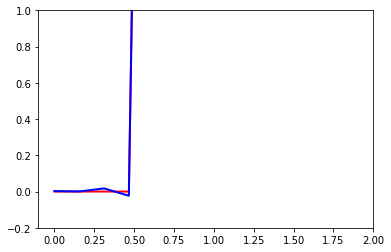

In [16]:
fig = plt.figure()
y=np.linspace(0,2*np.log(135),2**6)
ax = plt.axes(xlim=(-0.1, 2), ylim=(-0.2, 1))
line, = ax.plot(y,  linit[0]*np.real(checkwave(linit[1:])), 'r', lw=2)
line, = ax.plot(y,  sol[0]*np.real(checkwave(sol[1:])), 'b', lw=2)

In [31]:
n=6
dev = qml.device('default.qubit', wires=2*n-1)

@qml.qnode(dev)
def QNPU(l, l_old, O):
    wires=[]
    for i in range(2*n-1):
        wires.append(i)

    #Append first Hadamard Gate
    qml.Hadamard(wires=0)
    
    #Evaluates the expectation <ψ(lold)|1|ψ(lnew)>
    if O==0:
        bs.cSymU(params=l_old[1:], wires=[*wires[:n+1]])
        qml.inv(bs.cSymU(params=l[1:], wires=[*wires[:n+1]]))
    
    #Evaluates the expectation <ψ(lold)|A|ψ(lnew)>
    elif O==1:
        bs.cSymU(params=l_old[1:], wires=[wires[0], *wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
        qml.inv(bs.cSymU(params=l[1:], wires=[wires[0], *wires[n-1:2*n-1]]))
    
    #Evaluates the expectation <ψ(lold)|At|ψ(lnew)>
    elif O==2:
        bs.cSymU(params=l_old[1:], wires=[wires[0], *wires[n-1:2*n-1]])
        bs.cAdder(wires=wires,inverse=True)
        qml.inv(bs.cSymU(params=l[1:], wires=[wires[0], *wires[n-1:2*n-1]]))
    
    #Evaluates the expectation <ψ(lnew)|A|ψ(lnew)>
    elif O==3:
        bs.SymU(params=l[1:], wires=[*wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
    
    #Evaluates the expectation <ψ(lnew)|A^2|ψ(lnew)>
    elif O==4:
        bs.SymU(params=l[1:], wires=[*wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
        bs.cAdder(wires=wires)
        
    #Append second Hadamard Gate
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(wires=0))

In [58]:
#Black Scholes Parameters
S_max=135 #maximum stock price
K=50 #strike price
r=0.3 #risk-free interest rate
vol=0.2 #volatility
L = 2*np.log(S_max) #length of interval [-log S_max, log S_max] or [0, 2*log S_max]

In [59]:
def C(lnew,lold,t=0.5):
    n=6
    exp=[]
    for i in range(5):
        exp.append(QNPU(lnew, lold, i))
    
    alpha=1-r*t
    beta=(0.5*(vol**2)-r)*t
    gamma=0.5*(vol**2)*t
    
    term1=r-(vol**2)*(4**n/L**2)*(exp[3]-1)
    term2=r**2+((vol**2/2-r)**2+r*vol**2)*(4**n/L**2)*(2-2*exp[3])+(vol**4/4)*(4**(2*n)/L**4)*(2*exp[4]-8*exp[3]+6)
    
    term3=(alpha-2*gamma*4**n/L**2)*exp[0] + (gamma*4**n/L**2 - beta*2**(n-1)/L)*exp[1] +(gamma*4**n/L**2+beta*2**(n-1)/L)*exp[2]
    
    return lold[0]**2 + (lnew[0]**2)*(1-2*t*term1+(t**2)*term2)-2*lold[0]*lnew[0]*term3

In [67]:
def C_A(lnew,lold,t=0.5):
    n=6
    exp=[]
    for i in range(5):
        exp.append(QNPU(lnew, lold, i))
        
    alpha = 1-r*t
    beta = (1/2*vol-r)*t
    gamma = (1/2*vol)*t
    l0old = lold[0]
    l0 = lnew[0]
    return (l0old**2 + (l0**2)*(alpha**2+2*(beta**2)*(4**(n-1)/L**2)+6*(gamma**2)*(16**n/L**4)-4*alpha*gamma*(4**n/L**2))
            + 2*l0*(l0*((gamma**2)*(16**n/L**4)-(beta**2)*(4**(n-1)/L**2))*exp[4]
                  + l0*(2*alpha*gamma*(4**n/L**2)-4*(gamma**2)*(16**n/L**4))*exp[3]
                  - l0old*(beta*((2**(n-1))/L)+gamma*(4**n)/L**2)*exp[1]
                  + l0old*(beta*((2**(n-1))/L)-gamma*(4**n)/L**2)*exp[2]
                  + l0old*(2*gamma*((4**n)/L**2)-alpha)*exp[0]))

In [71]:
def time_evolve(params):
    
    opt1 = qml.AdamOptimizer(stepsize=0.1)

    params1 = params

    costs = 0
    best_params = None
    best_cost = 1e10
    
    def cost_function(l):
        return C_A(l,params)

    for i in range(1500):
        params1, costs = opt1.step_and_cost(lambda w: cost_function(w), params1)
        print(costs)
        if i % 100 == 0:
            print(params1)
        if best_cost > costs:
            best_cost = costs
            best_params = params1
    
  
    
    return best_params

    #print(best_cost)
    #print(best_params)

In [72]:
def time_evolve_n(n):
    sol = []
    l1 = time_evolve(linit)
    sol.append(l1)
    print("Initial condition is finished")
    for i in range(n):
        l1 = time_evolve(l1)
        sol.append(l1)
        print(str(i) + "th step is finished")
        
    return sol

In [54]:
solution = time_evolve_n(0)

30.84341505942575
[ 2.42999539e+02 -1.22958638e+00  1.17977027e+00  3.84347014e-01
  4.28138649e-01 -3.73177974e-01  3.76936856e-01  1.13825348e+00
  9.34881553e-01  4.66602659e-01 -4.98380239e-01  6.54845993e-01
  9.14789209e-01 -1.07035373e+00 -4.69018020e-01  6.37273684e-01
  1.73509477e+00  2.19120908e-01 -2.92348606e-01 -4.69182891e-02
  1.60783041e+00  2.95935176e-01 -1.79553841e+00  1.42291946e+00
 -1.42186197e+00  2.24415263e-01  1.27504825e+00 -1.60842472e+00
  1.61841186e+00  2.92137203e-01 -2.18625036e-01 -1.73633340e+00]
21.14795559288177
19.441672481698333
19.8036465413752
20.374003715754952
20.56051377944823
20.335857274680166
19.82987222725933
19.145631836960092
18.36262635041203
17.55696277496463
16.805537594482303
16.149138892287738
15.587029493588489
15.052748791014892
14.50879574479768
13.933376876855618
13.344716699619312
12.75053583412955
12.18238064351317
11.687373461041716
11.290220839873655
10.985850424374803
10.744572094961768
10.550821488694055
10.380273512637

7.003369580372237
7.002170511157601
7.001992499906919
7.002564333102782
7.00370309977734
7.005390516220359
7.007774569647154
7.011109812126961
7.015627015440259
7.0211848416074645
7.0267259254760575
7.029787408289849
7.027338368759956
7.018522949743783
7.007009976019617
6.998844611502136
6.997450248643872
7.001683604175923
7.007845881031244
7.01215653460531
7.012203678197693
7.007909667066997
7.001666748823482
6.996751367478282
6.99511345018982
6.996581425904878
6.9996824242552975
7.002769052502117
7.004635162724298
7.004701214027591
7.003034496185137
7.0002745328092715
6.997324065887369
6.994947884639259
6.993518734947429
6.993037578184158
6.993307987577282
6.9941284196975175
6.995415984667488
6.997249402847956
6.9998768491641385
7.003705971175805
7.009237217382179
7.016740255596233
7.025530644750688
7.032810186021379
7.033720563980751
7.024594115006039
7.008530902938219
6.994900241552386
6.991204324149294
6.997119262436172
7.0065745883766795
7.012625452669454
7.011155131200212
7.0032

In [73]:
#Abhi's cost function
solution_A = time_evolve_n(0)

2436.3620250518434
[ 2.43089539e+02 -1.11958638e+00  1.06977027e+00  4.94347014e-01
  5.18138649e-01 -4.63177974e-01  4.66936856e-01  1.04825348e+00
  8.44881553e-01  3.76602659e-01 -4.08380239e-01  7.44845993e-01
  8.24789209e-01 -1.16035373e+00 -3.79018020e-01  7.27273684e-01
  1.82509477e+00  1.29120908e-01 -3.82348606e-01  4.30817109e-02
  1.51783041e+00  3.85935176e-01 -1.70553841e+00  1.33291946e+00
 -1.33186197e+00  1.34415263e-01  1.18504825e+00 -1.51842472e+00
  1.52841186e+00  3.82137203e-01 -1.28625036e-01 -1.82633340e+00]
5933.398018793436
6232.617366214516
17223.80635539512
13642.0413702433
13293.982572622364
12141.03896389855
10016.519570562057
8752.172433443367
8389.621460805181
8295.948022208177
7450.070524992887
6887.398141639074
6341.353599778609
6446.301823828835
6302.806248969864
6293.45450505754
5799.550009956118
5068.461770150345
5080.302512330702
5634.719666445628
5240.062290132511
4248.50002914248
4688.5046515997965
5141.530548332958
4468.847523721866
4125.74759

1087.538126133848
1138.7502754484303
1144.8636770877056
1078.1988979114685
1015.0992704939563
1002.0111356433481
1004.393746040063
1016.0709946341813
1052.3299074331298
1069.1745775707532
1061.0123229660094
1089.9024594477378
1175.278250637697
1274.863323717611
1432.0867979926988
1685.7120228414424
1971.9556344791781
1801.264506645035
1275.68207227136
1090.1706545955967
1409.7485028344672
1385.0117934844457
1134.8516374437604
1245.3530242803972
1288.8551807082258
1076.0982007831335
1002.086185245309
1084.4179619767237
1127.9601967260242
1107.300522097852
1019.5894213607535
938.5544020808302
947.2414442957379
999.2348885920364
999.9488595272414
944.9074075280223
901.742291317787
888.8282210766338
895.9237762223929
900.8803234256338
885.516380221583
867.8160364052746
865.2822171174921
853.1469826791435
822.6670223593246
808.1388593777083
817.7466587524395
815.9405521657318
796.4497287753038
783.3876264793798
779.9839445655234
769.3324636653997
756.8655348536558
756.0362443653867
763.6226

505.25126310251653
551.3055278079119
476.41277046874166
465.3729244559072
609.4275055555627
692.4517925758846
655.09045675979
664.3606121083722
741.1045248666778
714.6139953255188
[ 2.86103989e+02 -1.25387494e+00  1.15251849e+00  3.96621933e-01
  5.56468788e-01 -5.27129660e-01  5.41555058e-01  9.91822051e-01
  1.18266284e+00  2.68281529e-01 -3.02857522e-01  4.22561464e-01
  1.13463901e+00 -1.27219755e+00 -2.76738769e-01  3.89887924e-01
  1.66570385e+00  1.06259371e-01 -1.14927280e-01 -2.68991396e-02
  1.57696374e+00  1.30710397e-01 -1.68918491e+00  1.48871643e+00
 -1.48915328e+00  1.15357551e-01  1.44532068e+00 -1.58534109e+00
  1.61389431e+00  1.16833151e-01 -1.09698219e-01 -1.66232145e+00]
555.6850693905726
429.3727609231137
416.49563869065605
442.8898771177046
469.9236074043438
486.71005777362734
448.9633563591633
375.8393188926857
349.8219163562171
378.91270999168046
412.6814131187275
435.55592341558076
451.9009934247006
444.1704241386615
402.17289645504206
363.10089022573084
360.2

401.768695759587
344.23836246388964
355.44745040265843
344.25169655447826
311.89806664921343
344.64264691178687
344.95447097625583
310.75427308445796
323.49862096691504
337.54130022460595
315.91845758492127
310.1423711942043
334.0945418693591
350.2233622230124
375.0537166870199
452.4042944116518
571.8386150593869
719.5010788992513
883.6323591587134
959.2675604089163
951.4341328744777
827.7667029562872
673.1029651812278
650.9943997520022
669.4705566528719
500.73226874973625
403.86288518924266
566.7655233668629
621.2967023954261
426.1671941021923
349.4772783599328
472.1461652724538
489.315390461823
368.3166638989933
336.9166485220194
402.5958673732821
407.57486026897095
359.10558730736375
357.2829280681908
390.6799628220033
393.9946014727466
378.1128149665892
391.72334377956577
430.573236458702
457.1065472192131
458.44474789500237
453.6665553324856
441.1718302904628
420.77347079641186
398.59275076771155
381.53242432605475
358.7645136208739
325.19735087640584
303.23231508838944
314.938075

486.99389202706516
440.39957583113573
485.6919369075913
521.5839562953915
489.2133658688981
443.74810405098833
422.16286312881857
400.8969005222898
377.89154253923334
374.94176176260225
374.1909587190021
350.13976261531934
[ 2.87838921e+02 -1.25014653e+00  1.16023945e+00  4.09424226e-01
  5.53589156e-01 -5.33490740e-01  5.47299730e-01  9.94359816e-01
  1.18354644e+00  2.61987292e-01 -2.92409826e-01  4.19573514e-01
  1.13569347e+00 -1.26988552e+00 -2.75734326e-01  3.85332475e-01
  1.67061423e+00  1.09789427e-01 -1.17357240e-01 -3.28121895e-02
  1.58271712e+00  1.30258303e-01 -1.68956583e+00  1.49003358e+00
 -1.48905003e+00  1.17981542e-01  1.44256020e+00 -1.58894235e+00
  1.60657638e+00  1.16310726e-01 -1.06929339e-01 -1.67039628e+00]
328.07182474737056
331.42682642955333
346.6087162217591
358.4564299641643
357.61968065728433
333.67868269747123
302.60006939969026
296.7184500636067
323.36335613694973
360.21026970422827
395.02238774998114
449.91956077096984
587.5432860488072
838.916286451

In [74]:
#Test circuit for outputting ansatz state given a set of params
def checkwave_circuit_out(params):
    """
    Args: params (nd.array): An array of optimizable parameters
    
    length of params should be 31
    """
    bs.U(params,wires=[0,1,2,3,4])
    
    
qml.enable_tape()
dev = qml.device('default.qubit', wires=5)

@qml.qnode(dev)
def checkwave_out(params):
    checkwave_circuit_out(params)
    return qml.state()

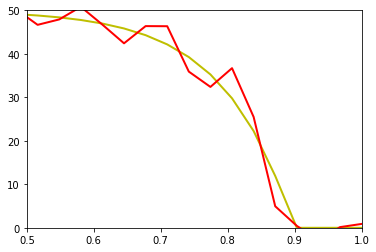

In [75]:
fig = plt.figure()
y=np.linspace(0,1,2**5)
ax = plt.axes(xlim=(0.5, 1), ylim=(0, 50))
line, = ax.plot(y,  linit[0]*np.real(checkwave_out(linit[1:])), 'y', lw=2)
line, = ax.plot(y,  solution[0][0]*np.real(checkwave_out(solution[0][1:])), 'r', lw=2)
#line2, = ax.plot(y,  solution[2][0]*np.real(checkwave_out(solution[2][1:])), 'c', lw=2)
#line3, = ax.plot(y,  solution[4][0]*np.real(checkwave(solution[4][1:])), 'm', lw=2)
#line4, = ax.plot(y,  solution[6][0]*np.real(checkwave_out(solution[6][1:])), 'g', lw=2)
#line5, = ax.plot(y,  solution[8][0]*np.real(checkwave(solution[8][1:])), 'k', lw=2)
#line6, = ax.plot(y,  solution[10][0]*np.real(checkwave_out(solution[10][1:])), 'b', lw=2)
#line7, = ax.plot(y,  solution[6][0]*np.real(checkwave(solution[6][1:])), 'y', lw=2)
#line7, = ax.plot(y,  solution[10][0]*np.real(checkwave(solution[10][1:])), 'k', lw=2)

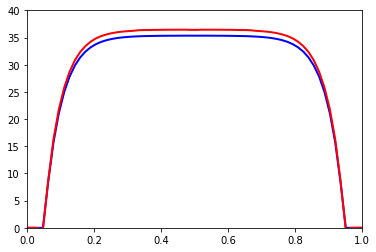

In [34]:
fig = plt.figure()
y=np.linspace(0,1,2**6)
ax = plt.axes(xlim=(0, 1), ylim=(0, 40))
line, = ax.plot(y,  linit[0]*np.real(checkwave(linit[1:])), 'b', lw=2)
line, = ax.plot(y,  best_params[0]*np.real(checkwave(best_params[1:])), 'r', lw=2)